In [1]:
#Auxiliary instructions that allow to run the scripts in the cloud
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/MateoRivera/network-dynamics/refs/heads/main/H1/init.py?token=GHSAT0AAAAAACZHWD3M4LTCY4SSOFRQD7KWZZFABIQ
from init import init; init(force_download=False)


In [2]:
#Libraries rewuired for the notebook
from scipy.io import loadmat
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import cvxpy as cp

%matplotlib inline

# **Exercise 3.**
We are given the highway network in Los Angeles, see Figure 2. To simplify the
problem, an approximate highway map is given in Figure 3, covering part of the real highway network. The node-link incidence matrix $B$, for this traffic network is given in the file `traffic.mat`. The rows of $B$ are associated with the nodes of the network and the columns of $B$ with the links. The $i$-th column of $B$ has $1$ in the row corresponding to the tail node of link $e_i$ and $(−1)$ in the row corresponding to the head node of link $e_i$ . Each node represents an intersection between highways (and some of the area around).

Each link $e_i \in \{e_1 , . . . , e_{28} \}$, has a maximum flow capacity $c_{ei}$. The capacities are given as a vector $c_e$ in the file `capacities.mat`. Furthermore, each link has a minimum travelling time lei, which the drivers experience when the road is empty. In the same manner as for the capacities, the minimum travelling times are given as a vector le in the file `traveltime.mat`. These values are simply retrieved by dividing the length of the highway segment with the assumed speed limit 60 miles/hour. For each link, we introduce the delay function
$$
  \tau_e(f_e) = \frac{l_e}{1 - \frac{f_e}{c_e}} , 0 \leqslant f_e < c_e
$$

For $f_e \ge c_e$ , the value of $ \tau_e(f_e)$ is considered as $+∞$.

First of all, we need to load the resources given for the excersice and construct the graph.

In [3]:
f = loadmat('resources/flow.mat')["flow"].reshape(28,)
C = loadmat('resources/capacities.mat')["capacities"].reshape(28,)
B = loadmat('resources/traffic.mat')["traffic"]
l = loadmat('resources/traveltime.mat')["traveltime"].reshape(28,)

In [4]:
labels = {(1,2):'l1',(2,3):'l2',(3,4):'l3',(4,5):'l4',(1,6):'l5',
          (6,7):'l6',(7,8):'l7',(8,9):'l8',(9,13):'l9',(2,7):'l10',
          (3,8):'l11',(3,9):'l12',(4,9):'l13',(5,14):'l14',(6,10):'l15',
          (10,11):'l16',(10,15):'l17',(7,10):'l18',(8,11):'l19',
          (9,12):'l20',(11,12):'l21',(12,13):'l22',(13,14):'l23',
          (11,15):'l24',(13,17):'l25',(14,17):'l26',(15,16):'l27',(16,17):'l26'}

In [5]:
W = [(
    np.argwhere(b==1).reshape(-1)[0]+1,
    np.argwhere(b==-1).reshape(-1)[0]+1,
    {'time': l[i], 'capacity':C[i]}) for i,b in enumerate(B.T)]

G = nx.DiGraph()
for w in W:
    G.add_edge(w[0],w[1], time=w[2]['time'], capacity=w[2]['capacity'])
pos = nx.nx_pydot.graphviz_layout(G)
edges = G.edges

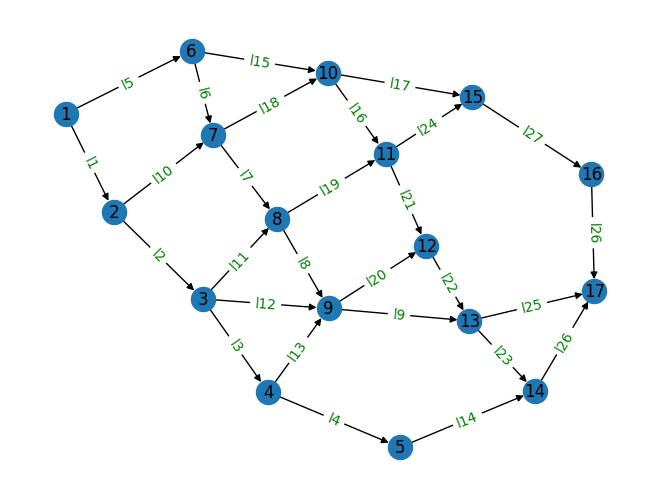

In [6]:
nx.draw(G,pos,with_labels=True)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels= labels,
    font_color='green'
)
plt.axis('off')
plt.show()



## **a)**
Find the shortest path between node 1 and 17. This is equivalent to the fastest path (path with shortest traveling time) in an empty network.



First, as a sanity check, we execute the shortest path algorithm provided by the `networkx`library

In [7]:
nx.shortest_path(G,1,17)

[1, 2, 3, 9, 13, 17]

Here we got that the shortest path in an empty network is $(1)→(2)→(3)→(9)→(13)→(17)$.



Now, let's compare it with the separable convex network flow optimization.

Given a multigraph $(V,E)$, and an **exogenous network flow** vector ${\nu} \in \mathrm{R}^V$ such that

\begin{equation}
	\sum_{i \in V} \nu_i = 0.
\end{equation}

Let $f \in \mathrm{R}^E$ be a network flow vector  satisfying the constraints

\begin{equation}
 f \ge \mathbf{0}, \quad Bf = \nu.
\end{equation}

And let $\psi_e(f_e)$ be a separable non-decreasing convex cost function $\psi_e(f_e)$ such that $\psi_e(0)=0$, this function is applied to every edge.

Therefore we have the following optimization problem, which will be solved using the library `cvxpy`:

\begin{equation}
\begin{aligned}
	f^* \in \ & \underset{\substack{f \in \mathrm{R}^{E}_+ \\ B f = \nu}}{\arg\min}
	& \sum_{e \in E} \psi_e (f_e).
\end{aligned}
\end{equation}



In [8]:
n_edges = B.shape[1]
n_nodes = B.shape[0]

tmp = np.zeros(n_nodes)
tmp[0] = 1
tmp[-1] = -1
# exogenous flow vector: one unit of flow enters the origin and exits the destination node
# the solution of the shortest path problem is actually independent on the throughput value because of the linearity
tau = 1
nu = tmp * tau



# Construct the problem.
flow = cp.Variable(n_edges)
objective = cp.Minimize(l.T @ flow)
constraints = [B @ flow == nu, flow >=0]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for f is stored in `flow.value`.
path = np.around(flow.value, decimals=0, out=None)
print("Optimal flow array:\n",  path)
print("Optimal path:", [f"l{i[0]+1}" for i in list(np.argwhere(path==1))])

Optimal flow array:
 [1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0.]
Optimal path: ['l1', 'l2', 'l9', 'l12', 'l25']


Therefore, following the order of edges proposed in the graph, the optiaml path to travel from $(1)$ to $(17)$ is:

$$(1) -l_1 → (2) -l_2 →(3)-l_{12} →(9)-l_9→ (13)-l_{25}→(17)$$

Which is congruent with the previous result using the shortest path algorithm.

## **b)**
Find the maximum flow between node 1 and 17.

For this excercise, lets use the `maximum_flow` algorithm available in the `Networkx` library.

In [9]:
value, Gflow = nx.algorithms.flow.maximum_flow(G, 1, 17, capacity='capacity')

In [10]:
found_flow = np.zeros(n_edges)
edge_list = [e for e in edges]

for el in Gflow:
  for val in Gflow[el]:
    found_flow[edge_list.index((el,val))] = Gflow[el][val]

print("Max flow is: ", value)
print("With flow vector:",end=" ")
print(found_flow)

Max flow is:  22448
With flow vector: [ 8741. 13707.  8741.     0.     0.     0.  8741.     0.     0.     0.
  4624.  9083.  4624.     0.  4624.     0.  6297.  7068.  3835. 10355.
  3835.   825.  8258.   825.     0.  8258.  7893.  8258.]


As seen in the output of the algorithm, the maximum flow between the nodes $1$ and $17$ is $22448$ and the flow distribution can be observed inside the links of the following graph

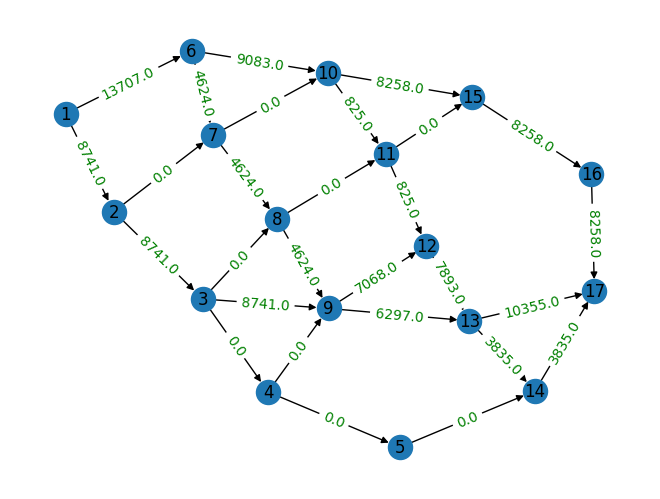

In [11]:
nx.draw(G,pos,with_labels=True)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels= {e:i for i,e in zip(found_flow,edges)},
    font_color='green'
)
plt.axis('off')
plt.show()

## **c)**
Given the flow vector in flow.mat, compute the vector $\nu$ satisfying $ Bf = \nu
$
We have to verify that
\begin{equation}
 f \ge \mathbf{0}
\end{equation}

In [12]:
f>= 0

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

and also
\begin{equation}
	\sum_{i \in V} \nu_i = 0.
\end{equation}

In [13]:
# Compute net flow at each node
v = B @ f

# Compute inflows and outflows.
inflows = [max(flow_value, 0) for flow_value in v]
outflows = [min(flow_value, 0) for flow_value in v]

print("The vector v is:", v)
# Here we are verifying that it satisfies the zero-sum constraint
print("The total net flow =", sum(v))

print("The inflow relative to the given flow vector f is: v_+ =", inflows) #positive values
print("The outflow relative to the given flow vector f is: v_- =", outflows) #negative values


The vector v is: [ 16282   9094  19448   4957   -746   4768    413     -2  -5671   1169
     -5  -7131   -380  -7412  -7810  -3430 -23544]
The total net flow = 0
The inflow relative to the given flow vector f is: v_+ = [16282, 9094, 19448, 4957, 0, 4768, 413, 0, 0, 1169, 0, 0, 0, 0, 0, 0, 0]
The outflow relative to the given flow vector f is: v_- = [0, 0, 0, 0, -746, 0, 0, -2, -5671, 0, -5, -7131, -380, -7412, -7810, -3430, -23544]


## **d)**
Find the social optimum $f^*$ with respect to the delays on the different links $\tau_e(f_e)$. For this, minimize the cost function subject to the flow constraints.
$$\sum_{e\in\mathcal{E}}f_e\tau_e(f_e)=\sum_{e\in\mathcal{E}}\frac{f_el_e}{1-f_e/c_e}=\sum_{e\in\mathcal{E}}\left(\frac{l_ec_e}{1-f_e/c_e}-l_ec_e\right)$$

For this excercise we apply again the separable convex network flow optimization, using the $\nu$ found in the previous excersise and the proposed cost function, the distribution is presented in the graph below.

In [14]:

# exogenous flow vector: one unit of flow enters the origin and
# exits the destination node
nu = np.zeros(v.shape[0])
nu[0] = v[0]
nu[-1] = -v[0]




# Construct the problem.
fe = cp.Variable(n_edges)
function = cp.sum(cp.multiply(cp.multiply(l,C),cp.inv_pos(1 - fe/C))- cp.multiply(l,C))
objective = cp.Minimize(function)
constraints = [B @ fe == nu, fe >=0, fe<=C]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
cost_opt = prob.solve()
# The optimal value for f is stored in `f.value`.
opt_flow = fe.value
print("Social optimal flow:", np.around(opt_flow, decimals=0, out=None))
print("Optimal cost:", np.around(cost_opt, decimals=2, out=None))
social_opt = fe


Social optimal flow: [6375. 5665. 2905. 2905. 9907. 4528. 2951. 2487. 3018.  709.    0. 2761.
    0. 2905. 5379. 2766. 4900. 2287.  463. 2230. 3229. 5459. 2307.    0.
 6170. 5212. 4900. 4900.]
Optimal cost: 23997.16


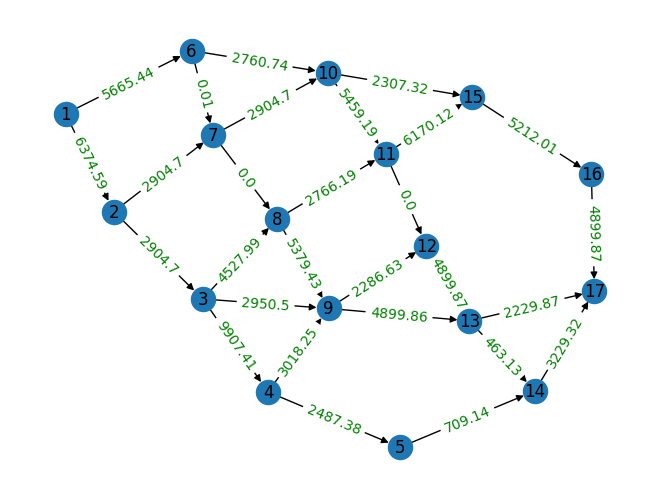

In [15]:
nx.draw(G,pos,with_labels=True)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels= {e:i for i,e in zip(np.around(opt_flow, decimals=2, out=None),edges)},
    font_color='green'
)
plt.axis('off')
plt.show()

## **e)**
Find the Wardrop equilibrium $f^{(0)}$. For this, use the cost function
$$
 min \sum_e \int_0^{f_e} \tau_e(s)~\mathrm{d}s.
$$

The solution of the expression:
$$
 min \sum_e \int_0^{f_e} \frac{l_e}{1 - \frac{s}{c_e}}~\mathrm{d}s.
$$
Is the objective function:
$$
\ min \sum_e -l_e c_e \ln\left(1 - \frac{f_e}{c_e}\right)
$$
Subject to constraints:
$$
 Bf = \nu, f \geq 0
$$

In [25]:
B # Traffic matrix
n_edges #Number of edges of B

# Exogenous flow vector:
# flow entering the origin node is set as v[0], flow exiting the destination node is -v[0].
nu = np.zeros(v.shape[0])
nu[0] = v[0]
nu[-1] = -v[0]

# Coefficients for objective function
C # diagonal matrix
l # 1d array
fe = cp.Variable(n_edges) # Variable representing the flow on each edge

# Construct the problem
function = -cp.sum(cp.multiply(cp.multiply(C, l), cp.log(1 - cp.multiply(fe, cp.inv_pos(C)))))
objective = cp.Minimize(function)
constraints = [B @ fe == nu, fe >=0]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned
result_w = prob.solve()
# The optimal value for f is stored in `fe.value`.
print("Wardrop equilibrium:", np.around(fe.value, decimals=1, out=None))


Wardrop equilibrium: [6349.6 6178.2 2037.9 2037.9 9932.4 4567.2 2738.1 2144.1 3270.7  171.5
   69.2 4071.1    0.  2037.9 5365.1 2203.  5162.7 2000.6  663.2 2944.5
 2866.2 5810.7 2436.6    0.  6644.8 4474.5 5162.7 5162.7]


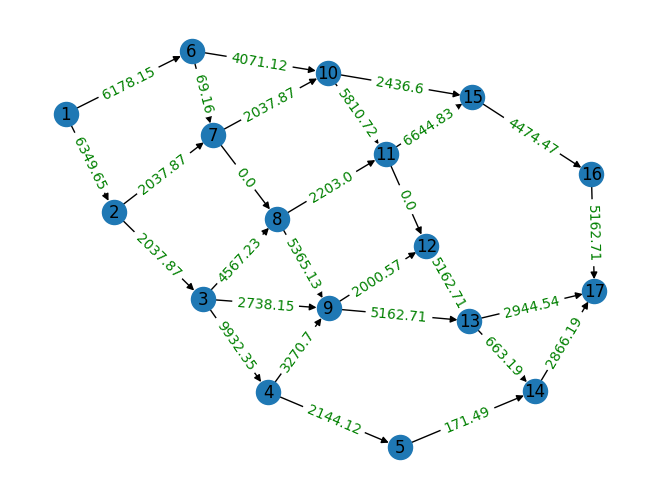

In [26]:
nx.draw(G,pos,with_labels=True)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels= {e:i for i,e in zip(np.around(fe.value, decimals=2, out=None),edges)},
    font_color='green'
)
plt.axis('off')
plt.show()

The social cost under Wardrop equilibrium is:
$$
\sum_{e}f_e^{(0)}\tau_e(f_e^{(0)}),
$$

In [18]:
wardrop_f = fe
wardrop_cost = sum(wardrop_f.value*l/(1 - wardrop_f.value/C))
print("Wardrop cost: ",  np.around(wardrop_cost, decimals=1, out=None))

Wardrop cost:  24341.2


## **f)**

Introduce tolls, such that the toll on link e is $ω_e = \psi_{e}'(f_e^{*})−\tau_e (f_e^*)$. For the considered $\psi_e(f_e)$, $\omega_e = f_e^* \tau_e'(f_e^* )$, where $f_e^∗$ is the flow at the system optimum. Now the delay on link e is given by $\tau_e(f_e ) + \omega_e$. compute the new Wardrop equilibrium $f ^{(ω)}$ . What do you observe?

In [34]:
# exogenous flow vector: one unit of flow enters the origin and
# exits the destination node
nu = np.zeros(v.shape[0])
nu[0] = v[0]
nu[-1] = -v[0]
# Q and l store the coefficients of the quadratic
# and linear terms of the objective function.


# Construct the problem.
fe = cp.Variable(n_edges)
t_prime = cp.multiply(cp.multiply(l,C),cp.inv_pos(cp.power((C - social_opt.value),2)))
omega = cp.multiply(social_opt.value,t_prime)
function = cp.sum(-cp.multiply(cp.multiply(C,l),cp.log(1-cp.multiply(fe,cp.inv_pos(C)))) + cp.multiply(fe,omega))
objective = cp.Minimize(function)
constraints = [B @ fe == nu, fe >=0]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result_w = prob.solve()
# The optimal value for f is stored in `f.value`.
print("Wardrop equilibrium with tolls:", np.around(fe.value, decimals=2, out=None))
tolls_f = fe
wardrop_tolls_cost = sum(tolls_f.value*l/(1 - tolls_f.value/C))
print("Wardrop cost with tolls: ", wardrop_tolls_cost)


Wardrop equilibrium with tolls: [6373.17 5665.64 2904.65 2904.65 9908.83 4527.78 2950.12 2486.97 3018.41
  707.54    0.   2760.98    0.   2904.65 5381.04 2766.46 4899.78 2285.2
  463.16 2229.53 3229.62 5459.15 2307.52    0.   6170.05 5212.17 4899.78
 4899.78]
Wardrop cost with tolls:  23997.162424961676


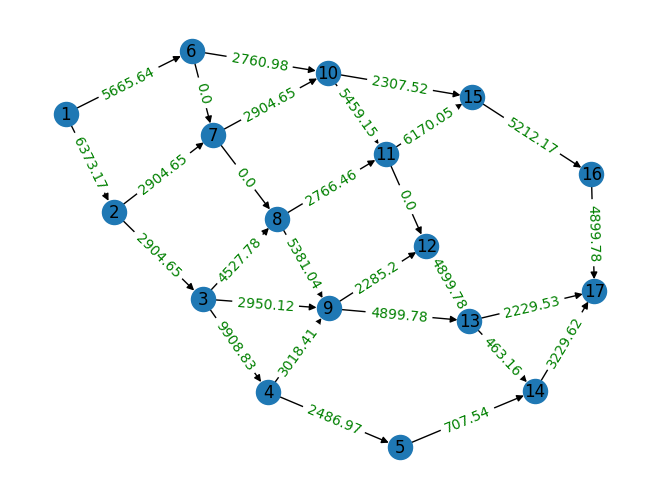

In [35]:
nx.draw(G,pos,with_labels=True)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels= {e:i for i,e in zip(np.around(tolls_f.value, decimals=2, out=None),edges)},
    font_color='green'
)
plt.axis('off')
plt.show()

In [36]:
# Substraction of the social optimum flow and wardrop equilibrium with tolls
np.around(opt_flow-tolls_f.value, decimals=2, out=None)

array([ 1.41, -0.19,  0.04,  0.04, -1.41,  0.2 ,  0.38,  0.42, -0.16,
        1.61,  0.01, -0.24,  0.  ,  0.04, -1.62, -0.27,  0.09,  1.43,
       -0.03,  0.33, -0.3 ,  0.03, -0.2 ,  0.  ,  0.07, -0.16,  0.09,
        0.09])

As seen in the graph and the substraction above, the wardrop equilibrium gives a very good aproximation of the social optimum $f^*$ obtained in the numeral **d)**

## **g)**

Instead of the total travel time, let the cost for the system be the total additional travel time compared to the total travel time in free flow, given by
$$
\psi_e (f_e) = f_e (\tau_e (f_e)- l_e)
$$

*   Compute the system optimum $f^*$ for the costs above.



From the numeral (d), we know:
$$
\sum_e f_e \tau_e(f_e) = \sum_e \left(\frac{l_e c_e}{1-\frac{f_e}{c_e}}-l_e c_e \right)
$$
The objective function will be:
$$
\psi_e (f_e) = min \sum_e \frac{l_e c_e}{1 - \frac{f_e}{c_e}} - l_e c_e - f_e l_e
$$
Subject to the constraints:
$$
 Bf = \nu, f \geq 0
$$

In [22]:
B # Traffic matrix
n_edges #Number of edges of B

# Exogenous flow vector:
# flow entering the origin node is set as v[0], flow exiting the destination node is -v[0].
nu = np.zeros(v.shape[0])
nu[0] = v[0]
nu[-1] = -v[0]

# Coefficients for objective function
C # diagonal matrix
l # 1d array
fe = cp.Variable(n_edges) # Variable representing the flow on each edge

# Construct the problem, psi function
function = cp.sum(cp.multiply(cp.multiply(l,C),cp.inv_pos(1 - fe/C))- cp.multiply(l,C) - cp.multiply(fe,l))
objective = cp.Minimize(function)
constraints = [B @ fe == nu, fe >=0]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned
result = prob.solve()

# The optimal value for f is stored in `f.value`.
print("System optimum f*:", np.around(fe.value, decimals=1, out=None))
print("Total cost = ", np.around(result, decimals=1))
new_soc_flow = fe
new_soc_opt_value = fe.value


System optimum f*: [6393.9 5420.8 3243.7 3243.7 9888.1 4530.6 3051.6 2612.1 2895.4  973.1
    0.  2177.1    0.  3243.7 5357.5 2969.8 4839.8 2452.1  439.5 1893.8
 3409.3 5303.  2140.2    0.  6058.3 5383.9 4839.8 4839.8]
Total cost =  13550.2


*   Construct a toll vector $\omega^* $ such that the Wardrop equilibrium
$ f^{(\omega^*)}$
coincides with $f^*$. Compute the new Wardrop equilibrium with the constructed tolls $f^{(w^*)}$to verify your result.




The toll vector is defined as:
$$
  \omega_e^* = f_e^* \tau_e'(f_e^*)
$$

In order to obtain the toll vector, we need to derivate the next expression and multiply it by $f_e^*$.

$$ \psi_e (f_e) = f_e (\tau_e (f_e)- l_e) $$

Since, $l_e$ is a constant, the result of the derivation is:
$$
  \tau_e'(f_e^*) = \frac{l_e c_e}{(c_e-f_e^*)^2}
$$


We also have that the objective function is:
$$
f^{(w^*)} =  min \sum_e \int_0^{f_e} \psi_e(s)~\mathrm{d}s + \omega_e^* f_e
$$

$$
f^{(w^*)} = min \sum_e -l_e c_e \ln\left(1 - \frac{f_e}{c_e}\right) - f_e l_e+ f_e \omega_e^*
$$

In [31]:
B # Traffic matrix
n_edges #Number of edges of B

# Exogenous flow vector:
# flow entering the origin node is set as v[0], flow exiting the destination node is -v[0].
nu = np.zeros(v.shape[0])
nu[0] = v[0]
nu[-1] = -v[0]

# Coefficients for objective function
C # diagonal matrix
l # 1d array
fe = cp.Variable(n_edges) # Variable representing the flow on each edge

t_prime = cp.multiply(cp.multiply(l,C),cp.inv_pos(cp.power((C - new_soc_opt_value),2)))
omega = cp.multiply(new_soc_opt_value,t_prime)

function = cp.sum(-cp.multiply(cp.multiply(C,l),cp.log(1-cp.multiply(fe,cp.inv_pos(C)))) - cp.multiply(fe,l) + cp.multiply(fe,omega))
objective = cp.Minimize(function)
constraints = [B @ fe == nu, fe >=0]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
new_result_w = prob.solve()
print("New Wardrop equilibrium:", np.around(fe.value, decimals=1, out=None))
new_wardrop_f = fe
new_wardrop_cost = sum(new_wardrop_f.value*l/(1 - new_wardrop_f.value/C) - new_wardrop_f.value*l)
print("New Wardrop cost: ",np.around (new_wardrop_cost, decimals = 1))

New Wardrop equilibrium: [6393.8 5420.9 3243.6 3243.6 9888.2 4530.6 3051.3 2611.9 2895.4  972.9
    0.  2177.3    0.  3243.6 5357.6 2969.9 4839.9 2452.2  439.4 1893.7
 3409.3 5303.1 2140.3    0.  6058.2 5383.9 4839.9 4839.9]
New Wardrop cost:  13550.2


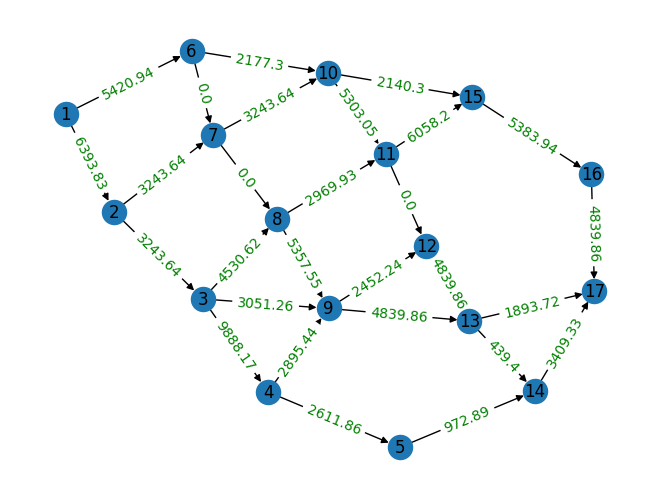

In [40]:
nx.draw(G,pos,with_labels=True)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels= {e:i for i,e in zip(np.around(new_wardrop_f.value,decimals=2, out=None),edges)},
    font_color='green'
)
plt.axis('off')
plt.show()

In [38]:
# Substraction of the social optimum flow and wardrop equilibrium with tolls
np.around(new_soc_opt_value-new_wardrop_f.value, decimals=2, out=None)

array([ 0.08, -0.14,  0.05,  0.05, -0.08, -0.06,  0.35,  0.24, -0.  ,
        0.22,  0.  , -0.19,  0.  ,  0.05, -0.02, -0.17, -0.04, -0.19,
        0.11,  0.05, -0.06, -0.01, -0.07,  0.  ,  0.06, -0.02, -0.04,
       -0.04])

As seen in the graph and the substraction above, the wardrop equilibrium gives a very good aproximation of the new social optimum $f^*$ calculated above.